# Weak lensing – Notebook 27th May 2024

Notebook tested with commit nb `xxx`.

Check requirements in `env.yml` (conda virtual environment).

The `pycs` package from the `cosmostat` repository (https://github.com/CosmoStat/cosmostat) could not be installed with `pip install .`. Therefore, the path to the git repository must be added to `PYTHONPATH` (see below). Tested with commit nb `a420193ced4bcd081f04a0afe0773aa4c120bfc8` (branch "hos").

The `pysparse` package from the `Sparse2D` repository  (https://github.com/CosmoStat/Sparse2D) needs to be manually installed. Tested with commit nb `3f9d54863765980299cfe92e0624ba93ed7ff02b`.

Very dirty workaround to avoid `ImportError: libpython3.11.so.1.0: cannot open shared object file: No such file or directory`: create a symbolic link from the `libpython3.11.so.1.0` file, which is typically stored in the `~/miniconda3/envs/wl-pycs/lib` (i.e., the directory for shared libraries within the virtual environment), to a standard root location such as `/lib/x86_64-linux-gnu`.

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle

import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import weaklensing as wl
import weaklensing.kappatng as wlktng
import weaklensing.cosmos as wlcosmos
import weaklensing.utils as wlutils
import weaklensing.cqr as wlcqr
import weaklensing.rcps as wlrcps

pycs_dir = os.path.expanduser(wl.CONFIG_DATA['pycs_dir'])
sys.path.append(pycs_dir) # tested with commit nb b7b39124de0ad444a89e27123e1791400edfe748 (branch "hos-hl")
print(f"The `pycs` package is located in {pycs_dir}")

import pycs.astro.wl.mass_mapping as csmm

Configuration file found in /home/leterme231/OneDrive/Documents/Code/weaklensing
The `pycs` package is located in /home/leterme231/OneDrive/Documents/Code/cosmostat


### Apply mass mapping with weighted convergence maps

In [3]:
size = 1.5
width, size = wlktng.get_npixels(size)
Nsigma = 4
Nrea = 25 # Number of noise realizations for UQ
print(f"Nb of pixels per side = {width}")
print(f"Opening angle = {size:.2f} deg")

Nb of pixels per side = 306
Opening angle = 1.49 deg


In [4]:
cat_cosmos = wlcosmos.cosmos_catalog(
    include_faint=False
)
data_cosmos = wlcosmos.get_data_from_cosmos(cat_cosmos, size)
extent = data_cosmos["extent"]
cosmos_mask, ra, dec = wlcosmos.cosmos_boundaries(extent, width)

Remove galaxies that are not in the redshift range of the $\kappa$-TNG dataset

In [5]:
cat_cosmos = cat_cosmos[cat_cosmos['zphot'] >= np.min(wlktng.LIST_OF_Z)]
cat_cosmos = cat_cosmos[cat_cosmos['zphot'] < np.max(wlktng.LIST_OF_Z)]

In [6]:
shapedisp1, shapedisp2 = data_cosmos["shapedisp"]
shapedisp = (shapedisp1 + shapedisp2) / 2

print(f"Shape dispersion 1 = {shapedisp1:.3f}")
print(f"Shape dispersion 2 = {shapedisp2:.3f}")

Shape dispersion 1 = 0.278
Shape dispersion 2 = 0.279


Get a list of weights, for each redshift in the $\kappa$-TNG dataset

In [7]:
weights_redshift = wlktng.get_weights(cat_cosmos['zphot'])

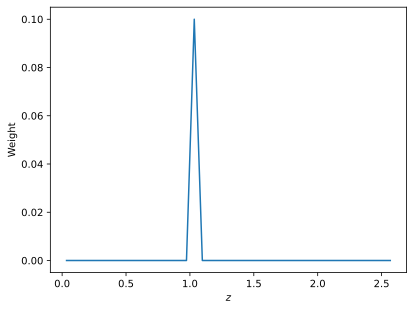

In [94]:
plt.plot(wlktng.LIST_OF_Z, weights_redshift)
plt.xlabel(r"$z$")
plt.ylabel("Weight")
plt.show()

Load $\kappa$-TNG dataset with a weighted combination of different redshifts

In [119]:
ninpimgs = 25
kappa = wlktng.kappa_tng(weights_redshift, ninpimgs, width=width)

In [120]:
np.linalg.norm(kappa[0])

0.43009511123196714

Number of galaxies per pixel

In [10]:
ngal = wlutils.ngal_per_pixel(cat_cosmos["Ra"], cat_cosmos["Dec"], width, extent)

Create noisy shear maps

In [11]:
gamma1, gamma2 = wlutils.get_shear_from_convergence(kappa)
gamma1_noisy, gamma2_noisy, std_noise = wlutils.get_masked_and_noisy_shear(
    gamma1, gamma2, ngal, shapedisp, stdnoise_mask=0
)

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:141: RuntimeWarning: divide by zero encountered in divide
  shapedisp / np.sqrt(ngal), posinf=stdnoise_mask


In [12]:
idx = 0
vmin = np.min(kappa)
vmax = np.max(kappa)
vmin_gamma = min(np.min(gamma1), np.min(gamma2))
vmax_gamma = max(np.max(gamma1), np.max(gamma2))
saturation = 0.4
saturation_gamma = 0.4

UQ parameters

In [13]:
confidence = 2. # Level of confidence (n-sigma)
alpha = wlutils.get_alpha_from_confidence(confidence)

min_nimgs_calib = wlutils.get_min_nimgs_calib(alpha)
print(f"Confidence level of {confidence}-sigma --> alpha = {alpha:.1%}")
print(f"Smallest possible size for the calibration set = {min_nimgs_calib}")

Confidence level of 2.0-sigma --> alpha = 4.6%
Smallest possible size for the calibration set = 21


In [14]:
nimgs_calib = 100
nimgs = kappa.shape[0]
nimgs_test = nimgs - nimgs_calib
print(f"Size of the calibration set = {nimgs_calib}")
print(f"Size of the test set = {nimgs_test}")

Size of the calibration set = 100
Size of the test set = 125


Register data into a `csmm.shear_data` object

In [15]:
sheardata = csmm.shear_data()
sheardata.g1 = gamma1_noisy
sheardata.g2 = gamma2_noisy
sheardata.mask = (ngal > 0).astype(int)
sheardata.Ncov = 2 * std_noise**2 # factor 2 required

Create a mass mapping structure and initialize it

In [16]:
massmap = csmm.massmap2d(name='mass')
massmap.init_massmap(width, width)
massmap.DEF_Nsigma = Nsigma

print(f"Number of iterations (iterative methods): {massmap.DEF_niter}")
print(f"Detection level in wavelet space: {massmap.DEF_Nsigma}")

Number of iterations (iterative methods): 12
Detection level in wavelet space: 4


Prepare visualization

In [17]:
path_to_paper = os.path.expanduser("~/Dropbox/postdoc-hubert/papers/2024-04_AA/img")

In [18]:
def skyshow_pred_bounds(
        pred, res, kappa, mask=None, showpred=True, vmax_bounds=0.23, savefig=True, filename=None
):
    lowerbound = pred - res - kappa
    upperbound = pred + res - kappa
    if mask is not None:
        lowerbound *= mask
        upperbound *= mask

    if showpred:
        plt.figure(figsize=(5, 3))
        wlutils.skyshow(
            pred, vmin=vmin, vmax=saturation*vmax, extent=extent,
            boundaries=(ra, dec), printxylabels=False,
            printxticks=False, printyticks=False
        )
        if savefig:
            plt.savefig(os.path.join(path_to_paper, f"{filename}.pdf"), bbox_inches='tight')
        plt.show()

    plt.figure(figsize=(5, 3))
    wlutils.skyshow(
        lowerbound,
        cmap="coolwarm", vmin=-vmax_bounds, vmax=vmax_bounds,
        extent=extent, boundaries=(ra, dec),
        printcolorbar=False, printxylabels=False, printxticks=False, printyticks=False
    )
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(-.2, .2, 5)) 
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}_low.pdf"), bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(5, 3))
    wlutils.skyshow(
        upperbound,
        cmap="coolwarm", vmin=-vmax_bounds, vmax=vmax_bounds,
        extent=extent, boundaries=(ra, dec),
        printcolorbar=False, printxylabels=False, printxticks=False, printyticks=False
    )
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(-.2, .2, 5)) 
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}_high.pdf"), bbox_inches='tight')
    plt.show()

#### Kaiser-Squires estimator

In [19]:
_, kappa_ks_lo, kappa_ks_hi, _ = wlutils.ksfilter(
    gamma1_noisy, gamma2_noisy,
    std_noise=std_noise, confidence=confidence
)
kappa_ks = (kappa_ks_lo + kappa_ks_hi) / 2
res_ks = (kappa_ks_hi - kappa_ks_lo) / 2

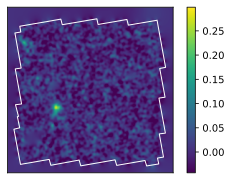

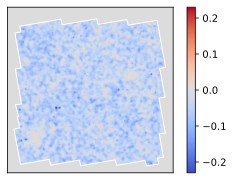

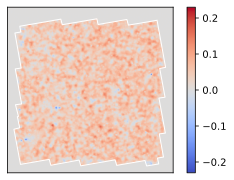

In [20]:
skyshow_pred_bounds(
    kappa_ks[idx], res_ks[idx], kappa[idx], mask=cosmos_mask, savefig=True, filename='ks'
)

#### Iterative Wiener algorithm

In [21]:
#!python ../scripts/massmapping.py wiener wiener_20240528.pred --Nsigma $Nsigma --ninpimgs $ninpimgs -v

In [22]:
pickle_dir = os.path.expanduser(wl.CONFIG_DATA['pickle_dir'])
fn = os.path.join(pickle_dir, 'wiener_20240528.pred')
with open(fn, 'rb') as f:
    _, kappa_wiener = pickle.load(f)

In [23]:
batch_size = kappa.shape[0] // Nrea # To avoid memory overload

In [24]:
#!python ../scripts/massmapping.py wiener wiener_20240528.uq --Nsigma $Nsigma --ninpimgs $ninpimgs \
#    -b $batch_size --uq --nsamples $Nrea -v

In [26]:
fn = os.path.join(pickle_dir, 'wiener_20240528.uq')
with open(fn, 'rb') as f:
    _, std_wiener = pickle.load(f)
res_wiener = confidence * std_wiener

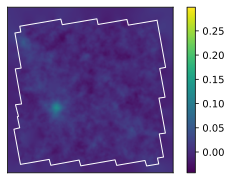

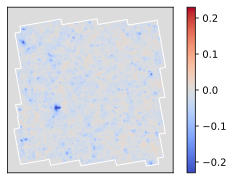

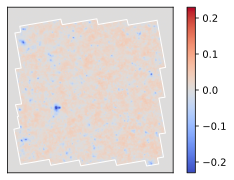

In [27]:
skyshow_pred_bounds(
    kappa_wiener[idx], res_wiener[idx], kappa[idx], mask=cosmos_mask, savefig=True, filename='wiener'
)

#### MCALens

In [28]:
#!python ../scripts/massmapping.py mcalens mcalens_20240528.pred --Nsigma $Nsigma --ninpimgs $ninpimgs -v

In [29]:
pickle_dir = os.path.expanduser(wl.CONFIG_DATA['pickle_dir'])
fn = os.path.join(pickle_dir, 'mcalens_20240528.pred')
with open(fn, 'rb') as f:
    _, kappa_mcalens, _ = pickle.load(f)

In [30]:
#!python ../scripts/massmapping.py mcalens mcalens_20240528.uq --Nsigma $Nsigma --ninpimgs $ninpimgs \
#    -b $batch_size --uq --nsamples $Nrea -v

In [31]:
fn = os.path.join(pickle_dir, 'mcalens_20240528.uq')
with open(fn, 'rb') as f:
    _, std_mcalens, _ = pickle.load(f)
res_mcalens = confidence * std_mcalens

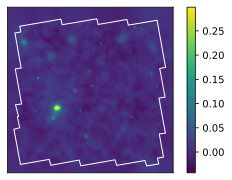

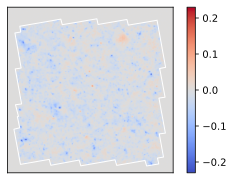

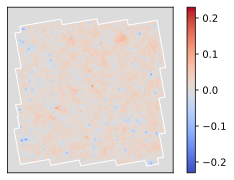

In [32]:
skyshow_pred_bounds(
    kappa_mcalens[idx], res_mcalens[idx], kappa[idx], mask=cosmos_mask, savefig=True, filename='mcalens'
)

### Split test and calibration sets

In [33]:
confidence = 2. # Level of confidence (n-sigma)
alpha = wlutils.get_alpha_from_confidence(confidence)

min_nimgs_calib = wlutils.get_min_nimgs_calib(alpha)
print(f"Confidence level of {confidence:.0f}-sigma --> alpha = {alpha:.1%}")
print(f"Smallest possible size for the calibration set = {min_nimgs_calib}")

Confidence level of 2-sigma --> alpha = 4.6%
Smallest possible size for the calibration set = 21


In [34]:
nimgs_calib = 100
nimgs = kappa.shape[0]
nimgs_test = nimgs - nimgs_calib
print(f"Size of the calibration set = {nimgs_calib}")
print(f"Size of the test set = {nimgs_test}")

Size of the calibration set = 100
Size of the test set = 125


In [35]:
[
    kappa_calib,
    kappa_ks_calib, kappa_wiener_calib, kappa_mcalens_calib,
    res_ks_calib, res_wiener_calib, res_mcalens_calib,
], [
    kappa_test,
    kappa_ks_test, kappa_wiener_test, kappa_mcalens_test,
    res_ks_test, res_wiener_test, res_mcalens_test,
] = \
    wlutils.split_test_calib([
        kappa,
        kappa_ks, kappa_wiener, kappa_mcalens,
        res_ks, res_wiener, res_mcalens,
    ], nimgs_calib, calib_first=False) # first the test set; then the calibration set

print(f"Size of the calibration set = {kappa_calib.shape[0]}")
print(f"Size of the test set = {kappa_test.shape[0]}")

Size of the calibration set = 100
Size of the test set = 125


### Quality of the estimated convergence maps

In [36]:
mse_ks_test = np.linalg.norm(kappa_ks_test - kappa_test, axis=(1, 2))**2
mse_wiener_test = np.linalg.norm(kappa_wiener_test - kappa_test, axis=(1, 2))**2
mse_mcalens_test = np.linalg.norm(kappa_mcalens_test - kappa_test, axis=(1, 2))**2

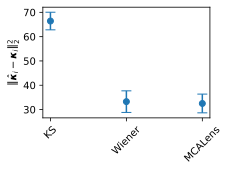

In [37]:
# Calculate mean and standard deviation for each statistical series
means = [np.mean(mse_ks_test), np.mean(mse_wiener_test), np.mean(mse_mcalens_test)]
std_devs = [np.std(mse_ks_test), np.std(mse_wiener_test), np.std(mse_mcalens_test)]

xticklabels_wlmm = ["KS", "Wiener", "MCALens"]

plt.figure(figsize=(3, 2))

# Plot means with error bars representing standard deviations
plt.errorbar(np.arange(1, 4), means, yerr=std_devs, fmt='o', capsize=5)

plt.xticks(np.arange(1, 4), xticklabels_wlmm, rotation=45)
plt.ylabel(r"$\left\|\hat{\boldsymbol{\kappa}}_i - \boldsymbol{\kappa}_i\right\|_2^2$")
#plt.savefig(os.path.join(path_to_paper, "mse.pdf"), bbox_inches='tight')
plt.show()

In [38]:
for method, mean, std in zip(xticklabels_wlmm, means, std_devs):
    print(f"{method} --> MSE = {mean:.1f} +/- {std:.1f}")

KS --> MSE = 66.4 +/- 3.6
Wiener --> MSE = 33.3 +/- 4.4
MCALens --> MSE = 32.5 +/- 3.8


Let us perform a statistical test to evaluate whether the MSE differences are statistically significant.

In [39]:
_, p_value_ks_vs_wiener = stats.ttest_ind(mse_ks_test, mse_wiener_test, equal_var=False)
_, p_value_wiener_vs_mcalens = stats.ttest_ind(mse_wiener_test, mse_mcalens_test, equal_var=False)

print(f"KS vs Wiener --> p-value = {p_value_ks_vs_wiener:.1e}")
print(f"Wiener vs MCALens --> p-value = {p_value_wiener_vs_mcalens:.1e}")

KS vs Wiener --> p-value = 8.5e-153
Wiener vs MCALens --> p-value = 1.5e-01


### Miscoverage rates and prediction interval before calibration

In [40]:
err_ks_test = wlutils.loss(
    kappa_ks_test - res_ks_test, kappa_ks_test + res_ks_test, kappa_test, mask=cosmos_mask
)
err_wiener_test = wlutils.loss(
    kappa_wiener_test - res_wiener_test, kappa_wiener_test + res_wiener_test, kappa_test, mask=cosmos_mask
)
err_mcalens_test = wlutils.loss(
    kappa_mcalens_test - res_mcalens_test, kappa_mcalens_test + res_mcalens_test, kappa_test, mask=cosmos_mask
)

In [41]:
predinterv_ks_test = wlutils.mean_predinterv(
    kappa_ks_test - res_ks_test, kappa_ks_test + res_ks_test, mask=cosmos_mask
)
predinterv_wiener_test = wlutils.mean_predinterv(
    kappa_wiener_test - res_wiener_test, kappa_wiener_test + res_wiener_test, mask=cosmos_mask
)
predinterv_mcalens_test = wlutils.mean_predinterv(
    kappa_mcalens_test - res_mcalens_test, kappa_mcalens_test + res_mcalens_test, mask=cosmos_mask
)

In [42]:
lower_ks_test = wlutils.mean_val(
    kappa_ks_test - res_ks_test, mask=cosmos_mask
)
lower_wiener_test = wlutils.mean_val(
    kappa_wiener_test - res_wiener_test, mask=cosmos_mask
)
lower_mcalens_test = wlutils.mean_val(
    kappa_mcalens_test - res_mcalens_test, mask=cosmos_mask
)

upper_ks_test = wlutils.mean_val(
    kappa_ks_test + res_ks_test, mask=cosmos_mask
)
upper_wiener_test = wlutils.mean_val(
    kappa_wiener_test + res_wiener_test, mask=cosmos_mask
)
upper_mcalens_test = wlutils.mean_val(
    kappa_mcalens_test + res_mcalens_test, mask=cosmos_mask
)

### CQR

In [43]:
def conformalize_get_metrics(
        cqr, pred_test, res_test, kappa_test, pred_calib, res_calib, kappa_calib,
        mask=None
):
    # Conformalize
    res_cqr_test, quantile_vals, _ = cqr.conformalize(
        res_test, pred_calib, res_calib, kappa_calib
    )

    # Discard quantile values outside the COSMOS boundaries
    if mask is not None:
        quantile_vals = quantile_vals[mask]

    kappa_lo_cqr_test = pred_test - res_cqr_test
    kappa_hi_cqr_test = pred_test + res_cqr_test

    # Error rate per image (over pixels)
    err_cqr_test = wlutils.loss(
        kappa_lo_cqr_test, kappa_hi_cqr_test, kappa_test, mask=mask
    )

    # Mean length of prediction intervals
    predinterv_cqr_test = wlutils.mean_predinterv(
        kappa_lo_cqr_test, kappa_hi_cqr_test, mask=mask
    )

    # Mean value for the lower and upper bounds
    lower_cqr_test = wlutils.mean_val(kappa_lo_cqr_test, mask=mask)
    upper_cqr_test = wlutils.mean_val(kappa_hi_cqr_test, mask=mask)

    return res_cqr_test, err_cqr_test, predinterv_cqr_test, lower_cqr_test, upper_cqr_test

#### Additive CQR

In [44]:
addcqr = wlcqr.AddCQR(alpha)

In [45]:
res_ks_addcqr_test, err_ks_addcqr_test, predinterv_ks_addcqr_test, \
        lower_ks_addcqr_test, upper_ks_addcqr_test = conformalize_get_metrics(
    addcqr, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
    mask=cosmos_mask
)

res_wiener_addcqr_test, err_wiener_addcqr_test, predinterv_wiener_addcqr_test, \
        lower_wiener_addcqr_test, upper_wiener_addcqr_test = conformalize_get_metrics(
    addcqr, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
    mask=cosmos_mask
)

res_mcalens_addcqr_test, err_mcalens_addcqr_test, predinterv_mcalens_addcqr_test, \
        lower_mcalens_addcqr_test, upper_mcalens_addcqr_test = conformalize_get_metrics(
    addcqr, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
    mask=cosmos_mask
)

#### Multiplicative CQR

In [46]:
multcqr = wlcqr.MultCQR(alpha)

In [47]:
res_ks_multcqr_test, err_ks_multcqr_test, predinterv_ks_multcqr_test, \
        lower_ks_multcqr_test, upper_ks_multcqr_test = conformalize_get_metrics(
    multcqr, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
    mask=cosmos_mask
)

res_wiener_multcqr_test, err_wiener_multcqr_test, predinterv_wiener_multcqr_test, \
        lower_wiener_multcqr_test, upper_wiener_multcqr_test = conformalize_get_metrics(
    multcqr, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
    mask=cosmos_mask
)

res_mcalens_multcqr_test, err_mcalens_multcqr_test, predinterv_mcalens_multcqr_test, \
        lower_mcalens_multcqr_test, upper_mcalens_multcqr_test = conformalize_get_metrics(
    multcqr, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
    mask=cosmos_mask
)

#### Chi-squared CQR

In [48]:
chisqcqr = wlcqr.ChisqCQR(alpha, mask=cosmos_mask)

In [49]:
res_ks_chisqcqr_test = []
res_wiener_chisqcqr_test = []
res_mcalens_chisqcqr_test = []

err_ks_chisqcqr_test = []
err_wiener_chisqcqr_test = []
err_mcalens_chisqcqr_test = []

predinterv_ks_chisqcqr_test = []
predinterv_wiener_chisqcqr_test = []
predinterv_mcalens_chisqcqr_test = []

lower_ks_chisqcqr_test = []
lower_wiener_chisqcqr_test = []
lower_mcalens_chisqcqr_test = []

upper_ks_chisqcqr_test = []
upper_wiener_chisqcqr_test = []
upper_mcalens_chisqcqr_test = []

In [50]:
scalefacts = np.linspace(.004, .012, 5)
for a in scalefacts:
    chisqcqr.a = a

    res_ks_chisqcqr_test_0, err_ks_chisqcqr_test_0, predinterv_ks_chisqcqr_test_0, \
            lower_ks_chisqcqr_test_0, upper_ks_chisqcqr_test_0 = conformalize_get_metrics(
        chisqcqr, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
        mask=cosmos_mask
    )
    res_ks_chisqcqr_test.append(res_ks_chisqcqr_test_0)
    err_ks_chisqcqr_test.append(err_ks_chisqcqr_test_0)
    predinterv_ks_chisqcqr_test.append(predinterv_ks_chisqcqr_test_0)
    lower_ks_chisqcqr_test.append(lower_ks_chisqcqr_test_0)
    upper_ks_chisqcqr_test.append(upper_ks_chisqcqr_test_0)

    res_wiener_chisqcqr_test_0, err_wiener_chisqcqr_test_0, predinterv_wiener_chisqcqr_test_0, \
            lower_wiener_chisqcqr_test_0, upper_wiener_chisqcqr_test_0 = conformalize_get_metrics(
        chisqcqr, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
        mask=cosmos_mask
    )
    res_wiener_chisqcqr_test.append(res_wiener_chisqcqr_test_0)
    err_wiener_chisqcqr_test.append(err_wiener_chisqcqr_test_0)
    predinterv_wiener_chisqcqr_test.append(predinterv_wiener_chisqcqr_test_0)
    lower_wiener_chisqcqr_test.append(lower_wiener_chisqcqr_test_0)
    upper_wiener_chisqcqr_test.append(upper_wiener_chisqcqr_test_0)

    res_mcalens_chisqcqr_test_0, err_mcalens_chisqcqr_test_0, predinterv_mcalens_chisqcqr_test_0, \
            lower_mcalens_chisqcqr_test_0, upper_mcalens_chisqcqr_test_0 = conformalize_get_metrics(
        chisqcqr, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
        mask=cosmos_mask
    )
    res_mcalens_chisqcqr_test.append(res_mcalens_chisqcqr_test_0)
    err_mcalens_chisqcqr_test.append(err_mcalens_chisqcqr_test_0)
    predinterv_mcalens_chisqcqr_test.append(predinterv_mcalens_chisqcqr_test_0)
    lower_mcalens_chisqcqr_test.append(lower_mcalens_chisqcqr_test_0)
    upper_mcalens_chisqcqr_test.append(upper_mcalens_chisqcqr_test_0)

In [51]:
list_of_err_ks_test = [
    err_ks_test, err_ks_addcqr_test, err_ks_multcqr_test, *err_ks_chisqcqr_test
]
list_of_err_wiener_test = [
    err_wiener_test, err_wiener_addcqr_test, err_wiener_multcqr_test, *err_wiener_chisqcqr_test
]
list_of_err_mcalens_test = [
    err_mcalens_test, err_mcalens_addcqr_test, err_mcalens_multcqr_test, *err_mcalens_chisqcqr_test
]

list_of_predinterv_ks_test = [
    predinterv_ks_test, predinterv_ks_addcqr_test, predinterv_ks_multcqr_test, *predinterv_ks_chisqcqr_test
]
list_of_predinterv_wiener_test = [
    predinterv_wiener_test, predinterv_wiener_addcqr_test, predinterv_wiener_multcqr_test,
    *predinterv_wiener_chisqcqr_test
]
list_of_predinterv_mcalens_test = [
    predinterv_mcalens_test, predinterv_mcalens_addcqr_test, predinterv_mcalens_multcqr_test,
    *predinterv_mcalens_chisqcqr_test
]

list_of_lower_ks_test = [
    lower_ks_test, lower_ks_addcqr_test, lower_ks_multcqr_test, *lower_ks_chisqcqr_test
]
list_of_lower_wiener_test = [
    lower_wiener_test, lower_wiener_addcqr_test, lower_wiener_multcqr_test, *lower_wiener_chisqcqr_test
]
list_of_lower_mcalens_test = [
    lower_mcalens_test, lower_mcalens_addcqr_test, lower_mcalens_multcqr_test, *lower_mcalens_chisqcqr_test
]

list_of_upper_ks_test = [
    upper_ks_test, upper_ks_addcqr_test, upper_ks_multcqr_test, *upper_ks_chisqcqr_test
]
list_of_upper_wiener_test = [
    upper_wiener_test, upper_wiener_addcqr_test, upper_wiener_multcqr_test, *upper_wiener_chisqcqr_test
]
list_of_upper_mcalens_test = [
    upper_mcalens_test, upper_mcalens_addcqr_test, upper_mcalens_multcqr_test, *upper_mcalens_chisqcqr_test
]

#### Visual representations

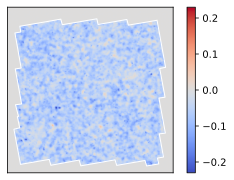

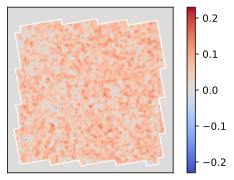

In [52]:
skyshow_pred_bounds(
    kappa_ks_test[idx], res_ks_addcqr_test[idx], kappa_test[idx], mask=cosmos_mask,
    showpred=False, savefig=False, filename='ks_addcqr'
)

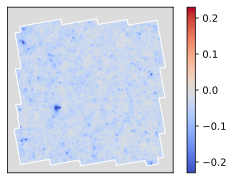

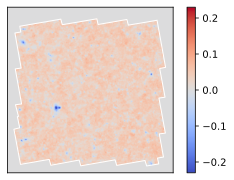

In [53]:
skyshow_pred_bounds(
    kappa_wiener_test[idx], res_wiener_addcqr_test[idx], kappa_test[idx], mask=cosmos_mask,
    showpred=False, savefig=False, filename='wiener_addcqr'
)

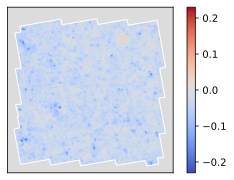

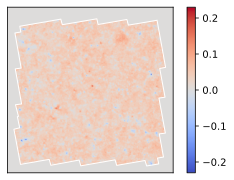

In [54]:
skyshow_pred_bounds(
    kappa_mcalens_test[idx], res_mcalens_addcqr_test[idx], kappa_test[idx], mask=cosmos_mask,
    showpred=False, savefig=False, filename='mcalens_addcqr'
)

#### Plot graphs

In [55]:
xticklabels_cqr = [
    "Uncalibrated", r"Additive", r"Multiplicative", r"$\chi^2$, $a =$.004", r"$\chi^2$, $a =$.006",
    r"$\chi^2$, $a =$.008", r"$\chi^2$, $a =$.010", r"$\chi^2$, $a =$.012"
]

Miscoverage rate

In [56]:
ylabel_err = r"$L\left(\boldsymbol{\kappa}_i,\, \hat{\boldsymbol{\kappa}}_i^-,\, \hat{\boldsymbol{\kappa}}_i^+\right)$"

In [57]:
def plot_means_errs(
        list_of_means, list_of_stds, xticklabels, sec_xticklabels=None,
        xlabel=None, ylabel=None, drawtarget=True, drawbounds=True,
        y_lower=None, y_upper=None, logscale=False, ymin=None, ymax=None, loclegend=None,
        keep_uncalibrated=True, savefig=True, filename=None
):
    """
    Plot means with error bars representing standard deviations
    
    """
    nseries = len(list_of_means)
    assert len(list_of_stds) == nseries
    if not keep_uncalibrated:
        xticklabels = xticklabels[1:]
    nvals = len(xticklabels)
    offset = 0.2  # Adjust the offset as needed
    labels = ["KS", "Wiener", "MCALens"]

    _, ax = plt.subplots(figsize=(6, 3))
    for i, (means, stds, label) in enumerate(zip(list_of_means, list_of_stds, labels)):
        x_values = np.arange(nvals) + 1 + (i - nseries // 2) * offset  # Adjusted x-coordinates
        if not keep_uncalibrated:
            means = means[1:]
            stds = stds[1:]
        plt.errorbar(x_values, means, yerr=stds, fmt='.', capsize=3, label=label)

    plt.xticks(np.arange(nvals) + 1, xticklabels, rotation=45)
    ax.set_xlim(0.5, nvals + 0.5)

    if sec_xticklabels is not None:
        sec_nvals = len(sec_xticklabels)
        sec_xticks = nvals / sec_nvals * np.arange(sec_nvals) + (nvals / sec_nvals + 1) / 2
        sec = ax.secondary_xaxis(location=0)
        sec.set_xticks(sec_xticks, labels=sec_xticklabels)
        sec.tick_params('x', length=0)

        # lines between the classes:
        sec_xticks = nvals / sec_nvals * np.arange(sec_nvals + 1) + 0.5
        sec2 = ax.secondary_xaxis(location=0)
        sec2.set_xticks(sec_xticks, labels=[])
        sec2.tick_params('x', length=70, width=1)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if drawtarget:
        plt.axhline(y=alpha, color='red', linestyle='--', linewidth=0.8, label=r'$\alpha$ (target)')
    if drawbounds:
        plt.axhspan(
            y_lower, y_upper,
            color='yellow', alpha=0.3, linewidth=0., label=r"Theoretical bounds for $\mathrm{\mathbb{E}}[L]$"
        )
    plt.legend(loc=loclegend)
    if logscale:
        plt.yscale('log')
    kwargs = {}
    if ymin is not None:
        kwargs.update(bottom=ymin)
    if ymax is not None:
        kwargs.update(top=ymax)
    if kwargs != {}:
        plt.ylim(**kwargs)
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}.pdf"), bbox_inches='tight')

    plt.show()

In [58]:
# Calculate mean and standard deviation for each statistical series
means_err_ks_cqr = [np.mean(err) for err in list_of_err_ks_test]
stds_err_ks_cqr = [np.std(err) for err in list_of_err_ks_test]

means_err_wiener_cqr = [np.mean(err) for err in list_of_err_wiener_test]
stds_err_wiener_cqr = [np.std(err) for err in list_of_err_wiener_test]

means_err_mcalens_cqr = [np.mean(err) for err in list_of_err_mcalens_test]
stds_err_mcalens_cqr = [np.std(err) for err in list_of_err_mcalens_test]

In [59]:
lower_bound_proba, upper_bound_proba = addcqr.get_bounds_proba(nimgs_calib)

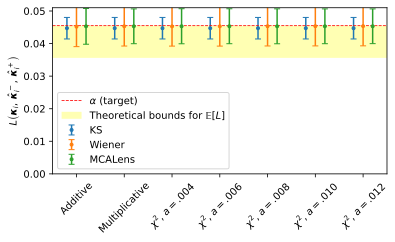

In [61]:
plot_means_errs(
    [means_err_ks_cqr, means_err_wiener_cqr, means_err_mcalens_cqr],
    [stds_err_ks_cqr, stds_err_wiener_cqr, stds_err_mcalens_cqr],
    xticklabels_cqr, ylabel=ylabel_err, y_lower=lower_bound_proba, y_upper=upper_bound_proba,
    ymin=0., ymax=0.051, keep_uncalibrated=False, savefig=False, filename="errs_cqr"
)

Lower and upper bounds of prediction intervals

In [62]:
ylabel_predinterv = (
    r"$\left\langle \hat{\boldsymbol{\kappa}}_i^- \right\rangle,\, "
    r"\left\langle \hat{\boldsymbol{\kappa}}_i^+ \right\rangle$"
)

In [63]:
def plot_confidence_bounds(
        list_of_lower, list_of_upper, xticklabels, sec_xticklabels=None,
        xlabel=None, ylabel=None, logscale=False, ymin=None, ymax=None, loclegend=None,
        keep_uncalibrated=True, savefig=True, filename=None
):
    """
    Plot minimum and maximum values.
    
    """
    nseries = len(list_of_lower)
    assert len(list_of_upper) == nseries
    if not keep_uncalibrated:
        xticklabels = xticklabels[1:]
    nvals = len(xticklabels)
    offset = 0.2  # Adjust the offset as needed
    labels = ["KS", "Wiener", "MCALens"]

    _, ax = plt.subplots(figsize=(6, 3))
    for i, (lower, upper, label) in enumerate(zip(list_of_lower, list_of_upper, labels)):
        x_values = np.arange(nvals) + 1 + (i - nseries // 2) * offset  # Adjusted x-coordinates
        if not keep_uncalibrated:
            lower = lower[1:]
            upper = upper[1:]
        lengths = [hi - lo for lo, hi in zip(lower, upper)]
        plt.bar(x_values, lengths, bottom=lower, width=0.1, label=label)

    plt.xticks(np.arange(nvals) + 1, xticklabels, rotation=45)
    ax.set_xlim(0.5, nvals + 0.5)

    if sec_xticklabels is not None:
        sec_nvals = len(sec_xticklabels)
        sec_xticks = nvals / sec_nvals * np.arange(sec_nvals) + (nvals / sec_nvals + 1) / 2
        sec = ax.secondary_xaxis(location=0)
        sec.set_xticks(sec_xticks, labels=sec_xticklabels)
        sec.tick_params('x', length=0)

        # lines between the classes:
        sec_xticks = nvals / sec_nvals * np.arange(sec_nvals + 1) + 0.5
        sec2 = ax.secondary_xaxis(location=0)
        sec2.set_xticks(sec_xticks, labels=[])
        sec2.tick_params('x', length=70, width=1)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.legend(loc=loclegend)
    if logscale:
        plt.yscale('log')
    kwargs = {}
    if ymin is not None:
        kwargs.update(bottom=ymin)
    if ymax is not None:
        kwargs.update(top=ymax)
    if kwargs != {}:
        plt.ylim(**kwargs)
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}.pdf"), bbox_inches='tight')

    plt.show()

In [64]:
# Calculate mean and standard deviation for each statistical series
means_lower_ks_cqr = [np.mean(lower) for lower in list_of_lower_ks_test]
means_upper_ks_cqr = [np.mean(upper) for upper in list_of_upper_ks_test]

means_lower_wiener_cqr = [np.mean(lower) for lower in list_of_lower_wiener_test]
means_upper_wiener_cqr = [np.mean(upper) for upper in list_of_upper_wiener_test]

means_lower_mcalens_cqr = [np.mean(lower) for lower in list_of_lower_mcalens_test]
means_upper_mcalens_cqr = [np.mean(upper) for upper in list_of_upper_mcalens_test]

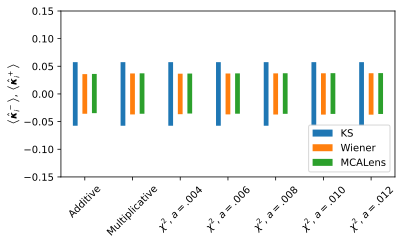

In [65]:
plot_confidence_bounds(
    [means_lower_ks_cqr, means_lower_wiener_cqr, means_lower_mcalens_cqr],
    [means_upper_ks_cqr, means_upper_wiener_cqr, means_upper_mcalens_cqr],
    xticklabels_cqr, ylabel=ylabel_predinterv, ymin=-0.15, ymax=0.15,
    keep_uncalibrated=False, loclegend="lower right", savefig=False, filename="confidencebounds_cqr"
)

### RCPS

In [66]:
def calibratercps_get_metrics(
        rcps, pred_test, res_test, kappa_test, pred_calib, res_calib, kappa_calib,
        mask=None
):
    # Calibrate
    res_rcps_test, lamb = rcps.calibrate(
        res_test, pred_calib, res_calib, kappa_calib, mask=mask
    )

    kappa_lo_rcps_test = pred_test - res_rcps_test
    kappa_hi_rcps_test = pred_test + res_rcps_test

    # Error rate per image (over pixels)
    err_rcps_test = wlutils.loss(
        kappa_lo_rcps_test, kappa_hi_rcps_test, kappa_test, mask=mask
    )

    # Mean length of prediction intervals
    predinterv_rcps_test = wlutils.mean_predinterv(
        kappa_lo_rcps_test, kappa_hi_rcps_test, mask=mask
    )

    # Mean value for the lower and upper bounds
    lower_rcps_test = wlutils.mean_val(kappa_lo_rcps_test, mask=mask)
    upper_rcps_test = wlutils.mean_val(kappa_hi_rcps_test, mask=mask)

    return res_rcps_test, err_rcps_test, predinterv_rcps_test, lower_rcps_test, upper_rcps_test, lamb

In [67]:
addrcps = wlrcps.BaseRCPS(alpha=alpha, delta=None, nimgs_calib=nimgs_calib)
min_delta = addrcps.get_min_delta()
print(f"Min value of delta = {min_delta:.2%}")

Min value of delta = 0.95%


In [68]:
#list_of_delta = np.logspace(-2, 0, 8)[1:-1]
list_of_delta = [0.05, 0.2, 0.5]
xlabel = r"$\delta$"
xticklabels_rcps = 3 * ["Additive", "Multiplicative"]
sec_xticklabels = [
    "\n\n\n\n\n" + r"$\delta =$" + f"{delta:.1%}" for delta in list_of_delta
]

#### Additive RCPS

In [69]:
addrcps = wlrcps.AddRCPS(alpha=alpha, delta=None, nimgs_calib=nimgs_calib)

delta = 5.0%
	Calibrate KS...


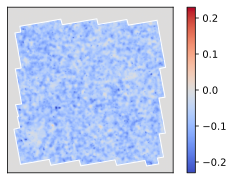

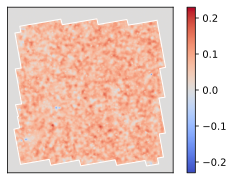

	Calibrate Wiener...


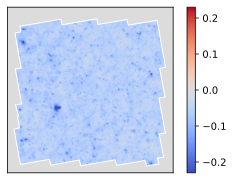

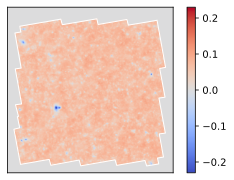

	Calibrate MCALens...


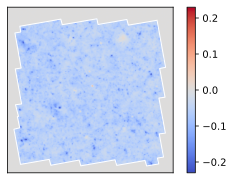

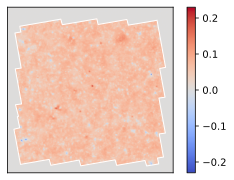

delta = 20.0%
	Calibrate KS...


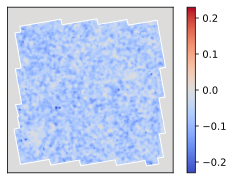

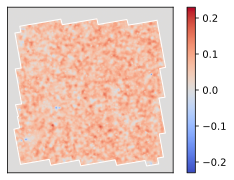

	Calibrate Wiener...


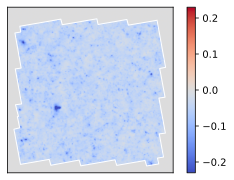

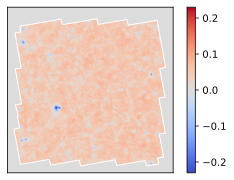

	Calibrate MCALens...


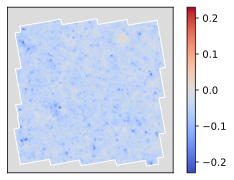

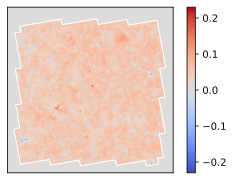

delta = 50.0%
	Calibrate KS...


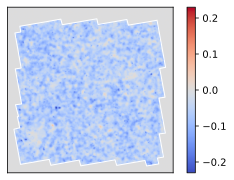

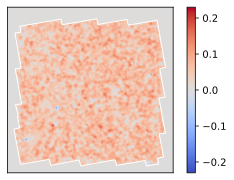

	Calibrate Wiener...


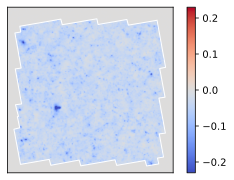

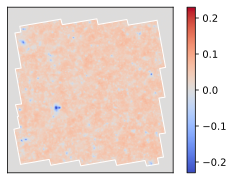

	Calibrate MCALens...


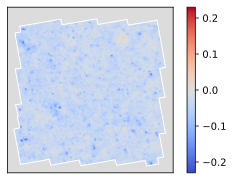

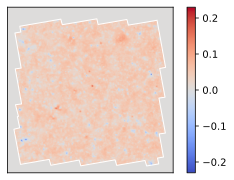

In [70]:
list_of_err_ks_addrcps_test = []
list_of_predinterv_ks_addrcps_test = []
list_of_lower_ks_addrcps_test = []
list_of_upper_ks_addrcps_test = []
list_of_lamb_ks_addrcps = []

list_of_err_wiener_addrcps_test = []
list_of_predinterv_wiener_addrcps_test = []
list_of_lower_wiener_addrcps_test = []
list_of_upper_wiener_addrcps_test = []
list_of_lamb_wiener_addrcps = []

list_of_err_mcalens_addrcps_test = []
list_of_predinterv_mcalens_addrcps_test = []
list_of_lower_mcalens_addrcps_test = []
list_of_upper_mcalens_addrcps_test = []
list_of_lamb_mcalens_addrcps = []

for delta in list_of_delta:
    print(f"delta = {delta:.1%}")
    addrcps.delta = delta

    print("\tCalibrate KS...")
    res_ks, err_ks, predinterv_ks, lower_ks, upper_ks, lamb_ks = calibratercps_get_metrics(
        addrcps, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
        mask=cosmos_mask
    )
    list_of_err_ks_addrcps_test.append(err_ks)
    list_of_predinterv_ks_addrcps_test.append(predinterv_ks)
    list_of_lower_ks_addrcps_test.append(lower_ks)
    list_of_upper_ks_addrcps_test.append(upper_ks)
    list_of_lamb_ks_addrcps.append(lamb_ks)
    skyshow_pred_bounds(
        kappa_ks_test[idx], res_ks[idx], kappa_test[idx], mask=cosmos_mask,
        showpred=False, savefig=False, filename=f'ks_addrcps_{delta:.1e}'
    )

    print("\tCalibrate Wiener...")
    res_wiener, err_wiener, predinterv_wiener, lower_wiener, upper_wiener, lamb_wiener = calibratercps_get_metrics(
        addrcps, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
        mask=cosmos_mask
    )
    list_of_err_wiener_addrcps_test.append(err_wiener)
    list_of_predinterv_wiener_addrcps_test.append(predinterv_wiener)
    list_of_lower_wiener_addrcps_test.append(lower_wiener)
    list_of_upper_wiener_addrcps_test.append(upper_wiener)
    list_of_lamb_wiener_addrcps.append(lamb_wiener)
    skyshow_pred_bounds(
        kappa_wiener_test[idx], res_wiener[idx], kappa_test[idx], mask=cosmos_mask,
        showpred=False, savefig=False, filename=f'wiener_addrcps_{delta:.1e}'
    )

    print("\tCalibrate MCALens...")
    res_mcalens, err_mcalens, predinterv_mcalens, lower_mcalens, upper_mcalens, lamb_mcalens = calibratercps_get_metrics(
        addrcps, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
        mask=cosmos_mask
    )
    list_of_err_mcalens_addrcps_test.append(err_mcalens)
    list_of_predinterv_mcalens_addrcps_test.append(predinterv_mcalens)
    list_of_lower_mcalens_addrcps_test.append(lower_mcalens)
    list_of_upper_mcalens_addrcps_test.append(upper_mcalens)
    list_of_lamb_mcalens_addrcps.append(lamb_mcalens)
    skyshow_pred_bounds(
        kappa_mcalens_test[idx], res_mcalens[idx], kappa_test[idx], mask=cosmos_mask,
        showpred=False, savefig=False, filename=f'mcalens_addrcps_{delta:.1e}'
    )

Calibration parameter

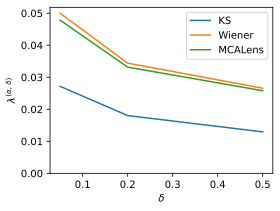

In [71]:
plt.figure(figsize=(4, 3))
plt.plot(list_of_delta, list_of_lamb_ks_addrcps, label='KS')
plt.plot(list_of_delta, list_of_lamb_wiener_addrcps, label='Wiener')
plt.plot(list_of_delta, list_of_lamb_mcalens_addrcps, label='MCALens')
plt.xlabel(r"$\delta$")
plt.ylabel(r"$\lambda^{(\alpha,\, \delta)}$")
plt.ylim(bottom=0.)
plt.legend()
plt.show()

#### Multiplicative RCPS

In [72]:
multrcps = wlrcps.MultRCPS(alpha=alpha, delta=None, nimgs_calib=nimgs_calib)

delta = 5.0%
	Calibrate KS...


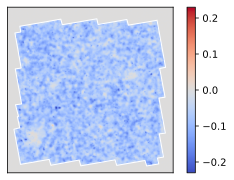

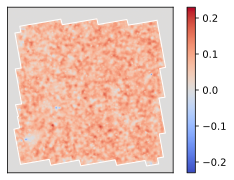

	Calibrate Wiener...


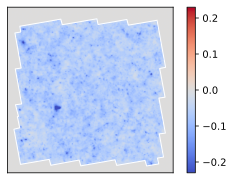

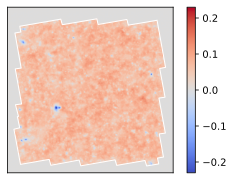

	Calibrate MCALens...


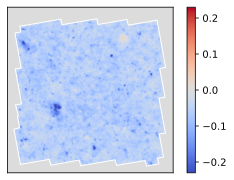

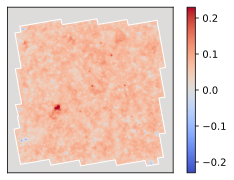

delta = 20.0%
	Calibrate KS...


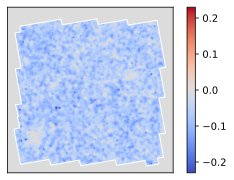

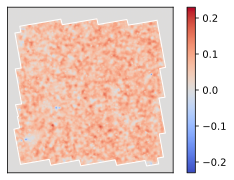

	Calibrate Wiener...


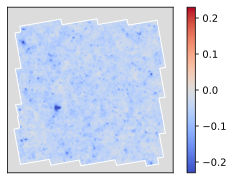

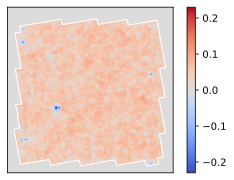

	Calibrate MCALens...


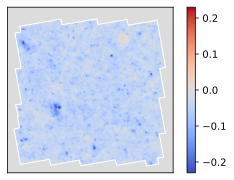

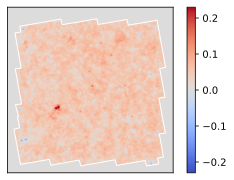

delta = 50.0%
	Calibrate KS...


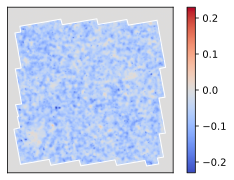

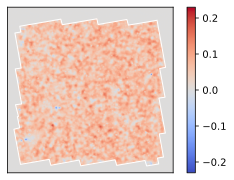

	Calibrate Wiener...


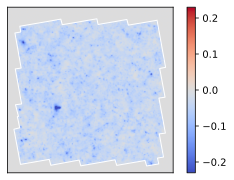

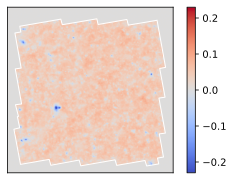

	Calibrate MCALens...


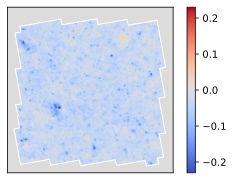

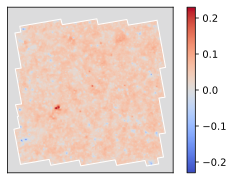

In [73]:
list_of_err_ks_multrcps_test = []
list_of_predinterv_ks_multrcps_test = []
list_of_lower_ks_multrcps_test = []
list_of_upper_ks_multrcps_test = []
list_of_lamb_ks_multrcps = []

list_of_err_wiener_multrcps_test = []
list_of_predinterv_wiener_multrcps_test = []
list_of_lower_wiener_multrcps_test = []
list_of_upper_wiener_multrcps_test = []
list_of_lamb_wiener_multrcps = []

list_of_err_mcalens_multrcps_test = []
list_of_predinterv_mcalens_multrcps_test = []
list_of_lower_mcalens_multrcps_test = []
list_of_upper_mcalens_multrcps_test = []
list_of_lamb_mcalens_multrcps = []

for delta in list_of_delta:
    print(f"delta = {delta:.1%}")
    multrcps.delta = delta

    print("\tCalibrate KS...")
    res_ks, err_ks, predinterv_ks, lower_ks, upper_ks, lamb_ks = calibratercps_get_metrics(
        multrcps, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
        mask=cosmos_mask
    )
    list_of_err_ks_multrcps_test.append(err_ks)
    list_of_predinterv_ks_multrcps_test.append(predinterv_ks)
    list_of_lower_ks_multrcps_test.append(lower_ks)
    list_of_upper_ks_multrcps_test.append(upper_ks)
    list_of_lamb_ks_multrcps.append(lamb_ks)
    skyshow_pred_bounds(
        kappa_ks_test[idx], res_ks[idx], kappa_test[idx], mask=cosmos_mask,
        showpred=False, savefig=False, filename=f'ks_multrcps_{delta:.1e}'
    )

    print("\tCalibrate Wiener...")
    res_wiener, err_wiener, predinterv_wiener, lower_wiener, upper_wiener, lamb_wiener = calibratercps_get_metrics(
        multrcps, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
        mask=cosmos_mask
    )
    list_of_err_wiener_multrcps_test.append(err_wiener)
    list_of_predinterv_wiener_multrcps_test.append(predinterv_wiener)
    list_of_lower_wiener_multrcps_test.append(lower_wiener)
    list_of_upper_wiener_multrcps_test.append(upper_wiener)
    list_of_lamb_wiener_multrcps.append(lamb_wiener)
    skyshow_pred_bounds(
        kappa_wiener_test[idx], res_wiener[idx], kappa_test[idx], mask=cosmos_mask,
        showpred=False, savefig=False, filename=f'wiener_multrcps_{delta:.1e}'
    )

    print("\tCalibrate MCALens...")
    res_mcalens, err_mcalens, predinterv_mcalens, lower_mcalens, upper_mcalens, lamb_mcalens = calibratercps_get_metrics(
        multrcps, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
        mask=cosmos_mask
    )
    list_of_err_mcalens_multrcps_test.append(err_mcalens)
    list_of_predinterv_mcalens_multrcps_test.append(predinterv_mcalens)
    list_of_lower_mcalens_multrcps_test.append(lower_mcalens)
    list_of_upper_mcalens_multrcps_test.append(upper_mcalens)
    list_of_lamb_mcalens_multrcps.append(lamb_mcalens)
    skyshow_pred_bounds(
        kappa_mcalens_test[idx], res_mcalens[idx], kappa_test[idx], mask=cosmos_mask,
        showpred=False, savefig=False, filename=f'mcalens_multrcps_{delta:.1e}'
    )

Calibration parameter

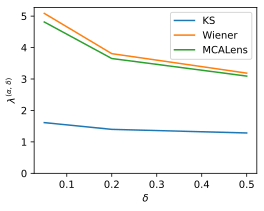

In [74]:
plt.figure(figsize=(4, 3))
plt.plot(list_of_delta, list_of_lamb_ks_multrcps, label='KS')
plt.plot(list_of_delta, list_of_lamb_wiener_multrcps, label='Wiener')
plt.plot(list_of_delta, list_of_lamb_mcalens_multrcps, label='MCALens')
plt.xlabel(r"$\delta$")
plt.ylabel(r"$\lambda^{(\alpha,\, \delta)}$")
plt.ylim(bottom=0.)
plt.legend()
plt.show()

#### Plot graphs

Miscoverage rate

In [75]:
# Calculate mean and standard deviation for each statistical series
means_err_ks_rcps = []
stds_err_ks_rcps = []
for err_add, err_mult in zip(
        list_of_err_ks_addrcps_test, list_of_err_ks_multrcps_test
):
    means_err_ks_rcps += [np.mean(err_add), np.mean(err_mult)]
    stds_err_ks_rcps += [np.std(err_add), np.std(err_mult)]

means_err_wiener_rcps = []
stds_err_wiener_rcps = []
for err_add, err_mult in zip(
        list_of_err_wiener_addrcps_test, list_of_err_wiener_multrcps_test
):
    means_err_wiener_rcps += [np.mean(err_add), np.mean(err_mult)]
    stds_err_wiener_rcps += [np.std(err_add), np.std(err_mult)]

means_err_mcalens_rcps = []
stds_err_mcalens_rcps = []
for err_add, err_mult in zip(
        list_of_err_mcalens_addrcps_test, list_of_err_mcalens_multrcps_test
):
    means_err_mcalens_rcps += [np.mean(err_add), np.mean(err_mult)]
    stds_err_mcalens_rcps += [np.std(err_add), np.std(err_mult)]

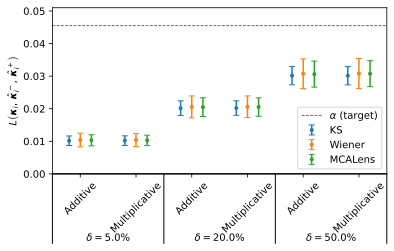

In [76]:
plot_means_errs(
    [means_err_ks_rcps, means_err_wiener_rcps, means_err_mcalens_rcps],
    [stds_err_ks_rcps, stds_err_wiener_rcps, stds_err_mcalens_rcps],
    xticklabels_rcps, sec_xticklabels=sec_xticklabels,
    ylabel=ylabel_err, drawbounds=False,
    ymin=0., ymax=0.051, savefig=False, filename="errs_rcps"
)

Mean length of prediction intervals

In [77]:
# Calculate mean and standard deviation for each statistical series
means_predinterv_ks_rcps = []
stds_predinterv_ks_rcps = []
for predinterv_add, predinterv_mult in zip(
        list_of_predinterv_ks_addrcps_test, list_of_predinterv_ks_multrcps_test
):
    means_predinterv_ks_rcps += [np.mean(predinterv_add), np.mean(predinterv_mult)]
    stds_predinterv_ks_rcps += [np.std(predinterv_add), np.std(predinterv_mult)]

means_predinterv_wiener_rcps = []
stds_predinterv_wiener_rcps = []
for predinterv_add, predinterv_mult in zip(
        list_of_predinterv_wiener_addrcps_test, list_of_predinterv_wiener_multrcps_test
):
    means_predinterv_wiener_rcps += [np.mean(predinterv_add), np.mean(predinterv_mult)]
    stds_predinterv_wiener_rcps += [np.std(predinterv_add), np.std(predinterv_mult)]

means_predinterv_mcalens_rcps = []
stds_predinterv_mcalens_rcps = []
for predinterv_add, predinterv_mult in zip(
        list_of_predinterv_mcalens_addrcps_test, list_of_predinterv_mcalens_multrcps_test
):
    means_predinterv_mcalens_rcps += [np.mean(predinterv_add), np.mean(predinterv_mult)]
    stds_predinterv_mcalens_rcps += [np.std(predinterv_add), np.std(predinterv_mult)]

In [78]:
means_lower_ks_rcps = []
means_upper_ks_rcps = []
for lower_add, lower_mult, upper_add, upper_mult in zip(
        list_of_lower_ks_addrcps_test, list_of_lower_ks_multrcps_test,
        list_of_upper_ks_addrcps_test, list_of_upper_ks_multrcps_test
):
    means_lower_ks_rcps += [np.mean(lower_add), np.mean(lower_mult)]
    means_upper_ks_rcps += [np.mean(upper_add), np.mean(upper_mult)]

means_lower_wiener_rcps = []
means_upper_wiener_rcps = []
for lower_add, lower_mult, upper_add, upper_mult in zip(
        list_of_lower_wiener_addrcps_test, list_of_lower_wiener_multrcps_test,
        list_of_upper_wiener_addrcps_test, list_of_upper_wiener_multrcps_test
):
    means_lower_wiener_rcps += [np.mean(lower_add), np.mean(lower_mult)]
    means_upper_wiener_rcps += [np.mean(upper_add), np.mean(upper_mult)]

means_lower_mcalens_rcps = []
means_upper_mcalens_rcps = []
for lower_add, lower_mult, upper_add, upper_mult in zip(
        list_of_lower_mcalens_addrcps_test, list_of_lower_mcalens_multrcps_test,
        list_of_upper_mcalens_addrcps_test, list_of_upper_mcalens_multrcps_test
):
    means_lower_mcalens_rcps += [np.mean(lower_add), np.mean(lower_mult)]
    means_upper_mcalens_rcps += [np.mean(upper_add), np.mean(upper_mult)]

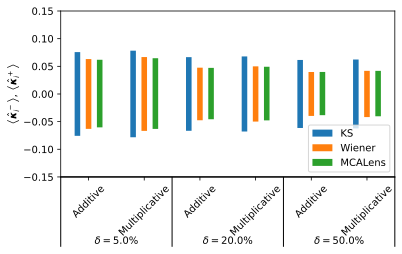

In [79]:
plot_confidence_bounds(
    [means_lower_ks_rcps, means_lower_wiener_rcps, means_lower_mcalens_rcps],
    [means_upper_ks_rcps, means_upper_wiener_rcps, means_upper_mcalens_rcps],
    xticklabels_rcps, sec_xticklabels=sec_xticklabels, ylabel=ylabel_predinterv,
    ymin=-0.15, ymax=0.15, savefig=False, filename="confidencebounds_rcps", loclegend="lower right"
)

#### Print results

In [80]:
list_of_means = list(zip(
    means_err_ks_rcps,
    means_err_wiener_rcps,
    means_err_mcalens_rcps,
    means_predinterv_ks_rcps,
    means_predinterv_wiener_rcps,
    means_predinterv_mcalens_rcps
))
list_of_stds = list(zip(
    stds_err_ks_rcps,
    stds_err_wiener_rcps,
    stds_err_mcalens_rcps,
    stds_predinterv_ks_rcps,
    stds_predinterv_wiener_rcps,
    stds_predinterv_mcalens_rcps
))

for means, stds in zip(list_of_means, list_of_stds):
    msg = ""
    for mean, std in zip(means, stds):
        msg += r" & $" + f"{100*mean:.2f}" + r" \pm " + f"{100*std:.2f}" + r"$"
    print(msg)

 & $1.02 \pm 0.15$ & $1.04 \pm 0.21$ & $1.03 \pm 0.17$ & $15.14 \pm 0.00$ & $12.62 \pm 0.02$ & $12.22 \pm 0.02$
 & $1.02 \pm 0.15$ & $1.04 \pm 0.20$ & $1.03 \pm 0.16$ & $15.65 \pm 0.00$ & $13.34 \pm 0.08$ & $12.78 \pm 0.11$
 & $2.02 \pm 0.22$ & $2.06 \pm 0.34$ & $2.05 \pm 0.29$ & $13.31 \pm 0.00$ & $9.50 \pm 0.02$ & $9.29 \pm 0.02$
 & $2.02 \pm 0.22$ & $2.06 \pm 0.33$ & $2.05 \pm 0.28$ & $13.57 \pm 0.00$ & $9.98 \pm 0.06$ & $9.69 \pm 0.09$
 & $3.02 \pm 0.28$ & $3.07 \pm 0.46$ & $3.06 \pm 0.40$ & $12.29 \pm 0.00$ & $7.94 \pm 0.02$ & $7.81 \pm 0.02$
 & $3.02 \pm 0.28$ & $3.08 \pm 0.46$ & $3.08 \pm 0.40$ & $12.46 \pm 0.00$ & $8.36 \pm 0.05$ & $8.21 \pm 0.07$
